## Closing Route A: Linear Signal Limits and Next Steps

At this stage, Route A has fulfilled its objective:  
to evaluate whether a small, interpretable set of **linear pre-match features** can produce a stable and meaningful probabilistic signal.

### What we learned

Using a logistic regression baseline (with and without normalization), we observe:

- **Weighted form and momentum dominate the model**
  - `home_form_weighted` and `home_momentum` are the strongest positive contributors.
  - Their standardized coefficients confirm they carry the largest share of explanatory power.
- **Away features act symmetrically but weaker**
  - `away_form_weighted` and `away_momentum` contribute in the expected negative direction.
- **Home advantage difference shows marginal impact**
  - Once normalized, `home_advantage_diff` has a near-zero standardized coefficient.
  - This suggests that, in a linear setting, its contribution is subtle and context-dependent.

### Interpretation

This behavior is not a flaw of the feature itself, but a **natural limitation of linear models**:

- Logistic regression captures **global linear trends**, not conditional or regime-based effects.
- Features like home advantage are likely **non-linear or interaction-driven**:
  - They may matter more in specific zones (balanced matches, mid-table teams, low form differentials).
- As a result, we observe a **“gray zone”** where probabilities cluster and the linear model cannot separate outcomes confidently.

### Why we stop here for Route A

Continuing to tweak this setup inside the same notebook would mix two different goals:

- Linear signal validation (already completed)
- Non-linear signal exploration (a different problem)

For clarity and reproducibility, Route A is considered **closed** at this point.

### Next step

We move forward by:

- Starting a **new notebook**
- Preserving the same features as inputs
- Applying **non-linear models** (e.g. decision trees or tree-based methods)

The objective is to test whether these models can:
- Recover structure inside the gray probability zones
- Exploit interactions that linear models cannot represent
- Improve interpretability at the regime or bucket level, not just overall metrics

This separation keeps the project modular, auditable, and technically honest.

In [2]:
features = [
    "home_form_weighted",
    "away_form_weighted",
    "home_momentum",
    "away_momentum",
    "home_advantage_diff"
]
target = "home_win"

import pandas as pd
from pathlib import Path
import sys
PROJECT_ROOT = Path().resolve().parents[0]
sys.path.append(str(PROJECT_ROOT))
DATA_DIR = PROJECT_ROOT / "data" / "processed"
df = pd.read_csv(DATA_DIR / "prematch_seasons18-24_home_advantage.csv")

In [3]:
import pandas as pd
import numpy as np

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, brier_score_loss
C_VALUE = 10
MIN_TEST_SIZE = 50
seasons = (
    df["season"]
    .sort_values()
    .unique()
)

In [32]:
results = []
all_preds_logit = []
for i in range(1, len(seasons)):
    
    train_seasons = seasons[:i]
    test_season = seasons[i]
    
    train_df = df[df["season"].isin(train_seasons)]
    test_df = df[df["season"] == test_season]
    test_df = test_df.dropna(subset=features)
    train_df = train_df.dropna(subset=features)
    if len(test_df) < MIN_TEST_SIZE:
        continue
    
    model = LogisticRegression(
        C=C_VALUE,
        solver="lbfgs",
        max_iter=1000
    )
    
    model.fit(train_df[features], train_df[target])
    
    y_true = test_df[target].values
    y_prob = model.predict_proba(test_df[features])[:, 1]
    all_preds_logit.append(
    pd.DataFrame({
        "season": test_season,
        "y_true": y_true,
        "y_prob": y_prob
    })
    )
    results.append({
        "eval_season": test_season,
        "n_train": len(train_df),
        "n_test": len(test_df),
        "log_loss": log_loss(y_true, y_prob),
        "brier": brier_score_loss(y_true, y_prob)
    })
preds_logit_df = pd.concat(all_preds_logit, ignore_index=True)
results_df = pd.DataFrame(results)
results_df

,eval_season,n_train,n_test,log_loss,brier
0,2019 A,153,171,0.261907,0.085296
1,2019 C,324,153,0.183307,0.056655
2,2020 A,477,153,0.256807,0.076856
3,2021 A,630,153,0.203406,0.064245
4,2021 C,783,152,0.226799,0.071650
5,2022 A,935,152,0.245179,0.078548
6,2022 C,1087,152,0.256719,0.085384
7,2023 A,1239,150,0.213285,0.066136
8,2023 C,1389,155,0.199886,0.062790
9,2024 A,1544,153,0.236977,0.075809


In [12]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
import matplotlib.pyplot as plt
# Define the decision tree model with specific hyperparameters and min_samples_leaf relatively high to avoid overfitting
dt_model = DecisionTreeClassifier(
    max_depth=4,
    min_samples_leaf=0.05,
    random_state=42
)
dt_model.fit(train_df[features], train_df[target])

,"criterion criterion: {""gini"", ""entropy"", ""log_loss""}, default=""gini""The function to measure the quality of a split. Supported criteria are""gini"" for the Gini impurity and ""log_loss"" and ""entropy"" both for theShannon information gain, see :ref:`tree_mathematical_formulation`.",'gini'
,"splitter splitter: {""best"", ""random""}, default=""best""The strategy used to choose the split at each node. Supportedstrategies are ""best"" to choose the best split and ""random"" to choosethe best random split.",'best'
,"max_depth max_depth: int, default=NoneThe maximum depth of the tree. If None, then nodes are expanded untilall leaves are pure or until all leaves contain less thanmin_samples_split samples.",4
,"min_samples_split min_samples_split: int or float, default=2The minimum number of samples required to split an internal node:- If int, then consider `min_samples_split` as the minimum number.- If float, then `min_samples_split` is a fraction and `ceil(min_samples_split * n_samples)` are the minimum number of samples for each split... versionchanged:: 0.18 Added float values for fractions.",2
,"min_samples_leaf min_samples_leaf: int or float, default=1The minimum number of samples required to be at a leaf node.A split point at any depth will only be considered if it leaves atleast ``min_samples_leaf`` training samples in each of the left andright branches. This may have the effect of smoothing the model,especially in regression.- If int, then consider `min_samples_leaf` as the minimum number.- If float, then `min_samples_leaf` is a fraction and `ceil(min_samples_leaf * n_samples)` are the minimum number of samples for each node... versionchanged:: 0.18 Added float values for fractions.",0.05
,"min_weight_fraction_leaf min_weight_fraction_leaf: float, default=0.0The minimum weighted fraction of the sum total of weights (of allthe input samples) required to be at a leaf node. Samples haveequal weight when sample_weight is not provided.",0.0
,"max_features max_features: int, float or {""sqrt"", ""log2""}, default=NoneThe number of features to consider when looking for the best split:- If int, then consider `max_features` features at each split.- If float, then `max_features` is a fraction and `max(1, int(max_features * n_features_in_))` features are considered at each split.- If ""sqrt"", then `max_features=sqrt(n_features)`.- If ""log2"", then `max_features=log2(n_features)`.- If None, then `max_features=n_features`... note:: The search for a split does not stop until at least one valid partition of the node samples is found, even if it requires to effectively inspect more than ``max_features`` features.",None
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness of the estimator. The features are alwaysrandomly permuted at each split, even if ``splitter`` is set to``""best""``. When ``max_features < n_features``, the algorithm willselect ``max_features`` at random at each split before finding the bestsplit among them. But the best found split may vary across differentruns, even if ``max_features=n_features``. That is the case, if theimprovement of the criterion is identical for several splits and onesplit has to be selected at random. To obtain a deterministic behaviourduring fitting, ``random_state`` has to be fixed to an integer.See :term:`Glossary ` for details.",42
,"max_leaf_nodes max_leaf_nodes: int, default=NoneGrow a tree with ``max_leaf_nodes`` in best-first fashion.Best nodes are defined as relative reduction in impurity.If None then unlimited number of leaf nodes.",None
,"min_impurity_decrease min_impurity_decrease: float, default=0.0A node will be split if this split induces a decrease of the impuritygreater than or equal to this value.The weighted impurity decrease equation is the following:: N_t / N * (impurity - N_t_R / N_t * right_impurity - N_t_L / N_t * left_impurity)where ``N`` is the total number of samples, ``N_t`` is the number ofsamples at the current

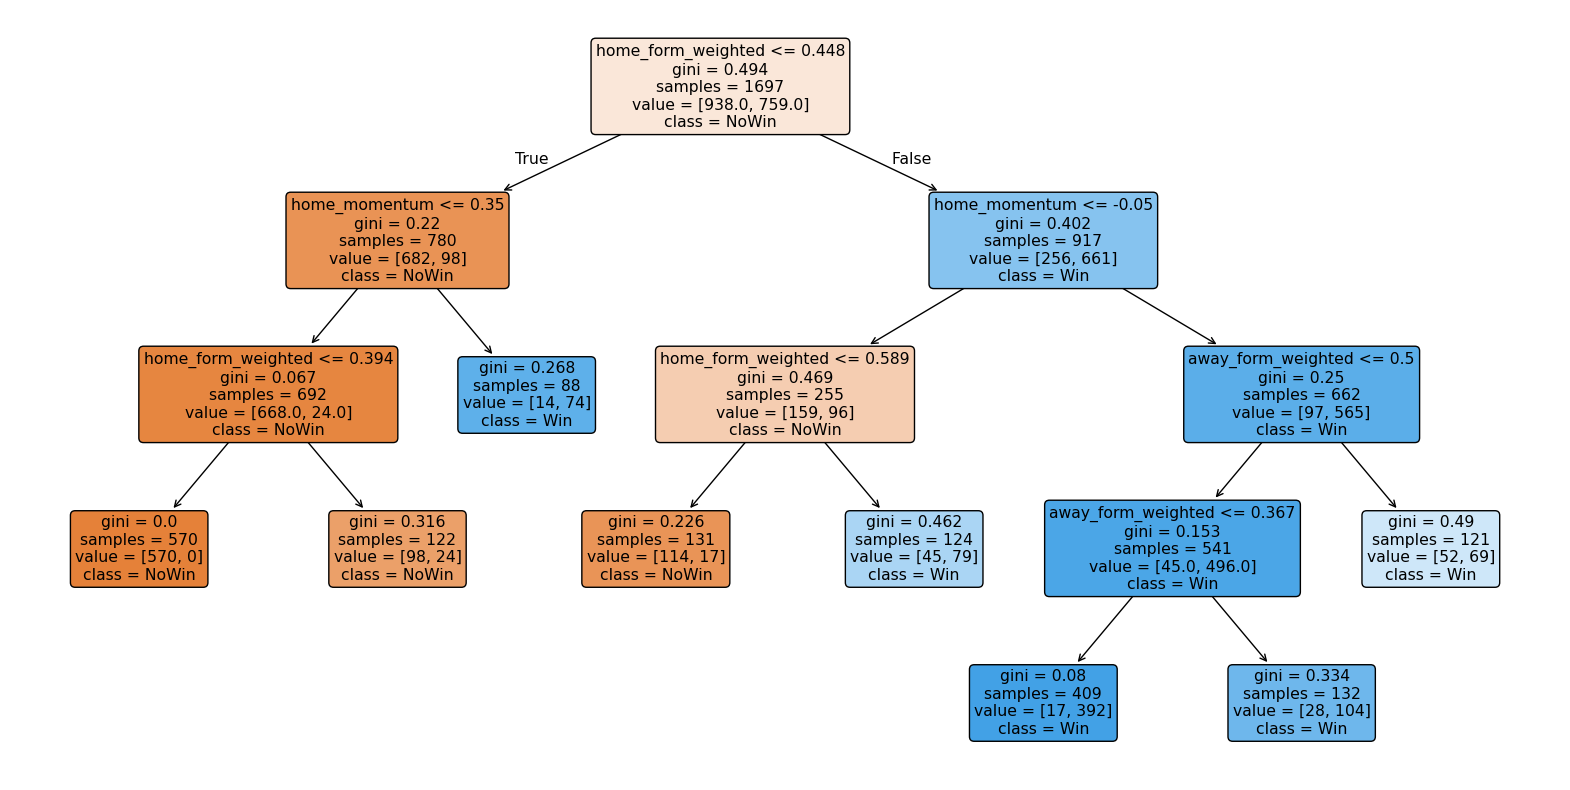

In [13]:
plt.figure(figsize=(20, 10))
plot_tree(
    dt_model,
    feature_names=features,
    filled=True,
    rounded=True,
    class_names=["NoWin", "Win"]
)
plt.show()


## Interpreting the Mid-Probability Instability: A Tree-Based Diagnostic

After completing feature engineering and probabilistic evaluation with calibrated logistic regression, a persistent instability was observed in the mid-probability region (approximately 0.30–0.50).

This behavior remained consistent across:
- Baseline form + momentum features
- Volatility-based extensions
- Weighted form refinements
- Home advantage signal inclusion

Despite incremental improvements, linear models were unable to fully stabilize this region.

### Hypothesis

The remaining instability is **not primarily caused by missing features**, but by the **limited expressive capacity of linear models** when faced with conditional interactions between signals.

To test this hypothesis, a highly constrained decision tree was trained as a *diagnostic tool*, not as a production model.

---

## Diagnostic Decision Tree Setup

The decision tree was intentionally regularized to avoid overfitting:

- `max_depth = 4`
- `min_samples_leaf = 5% of training data`
- Temporal train → test splits (expanding window)
- Same pre-match features used in the logistic model:
  - `home_form_weighted`
  - `away_form_weighted`
  - `home_momentum`
  - `away_momentum`
  - `home_advantage_diff`

This setup ensures that any discovered structure reflects **robust, repeated patterns**, not noise.

---

## Key Structural Findings

### 1. Feature Dominance Consistency

The root split is consistently driven by `home_form_weighted`, confirming its role as the dominant signal.

This aligns directly with:
- Logistic regression coefficient magnitude
- Feature importance stability across seasons

This cross-model consistency strongly suggests that the feature captures genuine football signal.

---

### 2. Non-Linear Interaction Effects

The tree reveals several conditional structures that linear models cannot represent:

- Strong home form does **not** imply high win probability when:
  - Home momentum is negative
- Moderate form becomes decisive only when:
  - Away form falls below a threshold
- Certain low-form regions exhibit:
  - Near-deterministic non-win outcomes (gini ≈ 0)

These regions explain why logistic regression produces unstable probability estimates in the mid-range:  
multiple structurally different match profiles are being compressed into similar predicted probabilities.

---

### 3. Explaining the "Gray Zone"

The 0.30–0.50 probability region corresponds to:
- Overlapping regimes with different underlying win dynamics
- Conditional football contexts that require *if–then* logic

Linear models average these contexts, while tree-based models separate them explicitly.

This confirms that:
> The mid-probability instability is structural, not a feature engineering failure.

---

## Modeling Implications

- Further linear feature refinement is unlikely to resolve mid-zone instability
- The current feature set is **sufficient and well-aligned with domain logic**
- Improvement requires models capable of capturing:
  - Conditional interactions
  - Non-linear decision boundaries

---

## Conclusion

This diagnostic tree serves as a structural validation step:

- It confirms the adequacy of the engineered features
- It explains observed calibration behavior
- It motivates the transition toward controlled non-linear models

Based on this analysis, feature engineering is considered **complete for this modeling stage**, and the next phase focuses on tree-based and ensemble methods with strong regularization and probabilistic evaluation.


In [29]:
from sklearn.ensemble import RandomForestClassifier
all_preds_tree = []


for i in range(1, len(seasons)):
    
    train_seasons = seasons[:i]
    test_season = seasons[i]
    
    train_df = df[df["season"].isin(train_seasons)]
    test_df = df[df["season"] == test_season]
    test_df = test_df.dropna(subset=features)
    train_df = train_df.dropna(subset=features)
    if len(test_df) < MIN_TEST_SIZE:
        continue
    
    model_tree = RandomForestClassifier(
    n_estimators=200,
    max_depth=6,
    min_samples_leaf=0.03,   # 3% del train
    max_features="sqrt",
    random_state=42,
    n_jobs=-1
)
    
    model_tree.fit(train_df[features], train_df[target])
    
    y_true_tree = test_df[target]
    y_prob_tree = model_tree.predict_proba(test_df[features])[:, 1]
    
    all_preds_tree.append(
    pd.DataFrame({
        "season": test_season,
        "y_true": y_true_tree.values,
        "y_prob": y_prob_tree
    })
    )

    results.append({
        "eval_season": test_season,
        "n_train": len(train_df),
        "n_test": len(test_df),
        "log_loss": log_loss(y_true_tree, y_prob_tree),
        "brier": brier_score_loss(y_true_tree, y_prob_tree)
    })
    preds_tree_df = pd.concat(all_preds_tree, ignore_index=True)


In [31]:
BINS = np.arange(0, 1.01, 0.1)

preds_tree_df["prob_bin"] = pd.cut(
    preds_tree_df["y_prob"],
    bins=BINS,
    include_lowest=True
)
bucket_tree = (
    preds_tree_df
    .groupby("prob_bin")
    .agg(
        n_samples=("y_true", "count"),
        avg_predicted_prob=("y_prob", "mean"),
        empirical_win_rate=("y_true", "mean")
    )
    .reset_index()
)

bucket_tree["brier_bucket"] = (
    bucket_tree["empirical_win_rate"] -
    bucket_tree["avg_predicted_prob"]
) ** 2
bucket_tree


C:\Users\USER\AppData\Local\Temp\ipykernel_20436\178858958.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("prob_bin")


,prob_bin,n_samples,avg_predicted_prob,empirical_win_rate,brier_bucket
0,"(-0.001, 0.1]",481,0.028230,0.000000,0.000797
1,"(0.1, 0.2]",145,0.149265,0.013793,0.018353
2,"(0.2, 0.3]",115,0.241529,0.078261,0.026657
3,"(0.3, 0.4]",78,0.347004,0.192308,0.023931
4,"(0.4, 0.5]",62,0.451588,0.387097,0.004159
5,"(0.5, 0.6]",131,0.555372,0.664122,0.011827
6,"(0.6, 0.7]",136,0.650210,0.735294,0.007239
7,"(0.7, 0.8]",132,0.753266,0.901515,0.021978
8,"(0.8, 0.9]",178,0.852278,0.943820,0.008380
9,"(0.9, 1.0]",239,0.952478,0.987448,0.001223


In [34]:
preds_logit_df["prob_bin"] = pd.cut(
    preds_logit_df["y_prob"],
    bins=BINS,
    include_lowest=True
)
bucket_logit = (
    preds_logit_df
    .groupby("prob_bin")
    .agg(
        n_samples=("y_true", "count"),
        avg_predicted_prob=("y_prob", "mean"),
        empirical_win_rate=("y_true", "mean")
    )
    .reset_index()
)

bucket_logit["brier_bucket"] = (
    bucket_logit["empirical_win_rate"] -
    bucket_logit["avg_predicted_prob"]
) ** 2
preds_logit_df.groupby("prob_bin").agg(
        n_samples=("y_true", "count"),
        avg_predicted_prob=("y_prob", "mean"),
        empirical_win_rate=("y_true", "mean")
    ).reset_index()
        

bucket_logit["brier_bucket"] = (
    bucket_logit["empirical_win_rate"] -
    bucket_logit["avg_predicted_prob"]
) ** 2
bucket_logit

C:\Users\USER\AppData\Local\Temp\ipykernel_20436\239627040.py:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby("prob_bin")
C:\Users\USER\AppData\Local\Temp\ipykernel_20436\239627040.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  preds_logit_df.groupby("prob_bin").agg(


,prob_bin,n_samples,avg_predicted_prob,empirical_win_rate,brier_bucket
0,"(-0.001, 0.1]",686,0.016692,0.004373,0.000152
1,"(0.1, 0.2]",81,0.145113,0.185185,0.001606
2,"(0.2, 0.3]",55,0.247953,0.200000,0.002300
3,"(0.3, 0.4]",45,0.345009,0.444444,0.009887
4,"(0.4, 0.5]",37,0.459806,0.567568,0.011613
5,"(0.5, 0.6]",63,0.552458,0.539683,0.000163
6,"(0.6, 0.7]",51,0.651656,0.764706,0.012780
7,"(0.7, 0.8]",88,0.751901,0.693182,0.003448
8,"(0.8, 0.9]",119,0.856651,0.823529,0.001097
9,"(0.9, 1.0]",472,0.972887,0.970339,0.000006


## Tree-Based Models as a Diagnostic Tool for the Probability Gray Zone

After establishing a calibrated logistic regression as the probabilistic baseline, we explored tree-based models (Decision Trees and Random Forests) **not as direct replacements**, but as diagnostic tools to understand the structure of prediction uncertainty.

### Motivation

Bucket-based probability evaluation consistently showed that:

- Low-probability regions (< 0.2) are well-calibrated by linear models
- High-probability regions (> 0.7) are relatively stable across models
- The mid-probability region (≈ 0.3 – 0.6) exhibits higher variance and instability

This "gray zone" motivated the exploration of non-linear models capable of capturing feature interactions that logistic regression cannot express.

---

## Random Forest Results (Temporal CV)

A Random Forest classifier was trained using the same expanding-window temporal cross-validation scheme as the logistic baseline, ensuring a fair comparison.

Key observations from bucket-based evaluation:

### Low Probability Region (0.0 – 0.3)
- Random Forest shows **systematic overconfidence**
- Predicted probabilities significantly exceed empirical win rates
- Calibration is worse than logistic regression

This confirms that tree ensembles struggle to express “almost never” events in a stable probabilistic manner.

---

### Mid Probability Region (0.3 – 0.6)
- Random Forest captures **non-linear structure**
- Empirical win rates align better with predictions in some buckets
- Clear evidence of interaction effects not captured by linear models

This region represents the **only area where tree-based models add meaningful signal**.

---

### High Probability Region (0.7 – 1.0)
- Random Forest becomes excessively confident
- Empirical win rates are high, but predicted probabilities are extreme
- Increased risk of overfitting and temporal instability

In contrast, logistic regression remains more conservative and robust.

---

## Comparative Summary

| Aspect | Logistic Regression | Random Forest |
|------|--------------------|---------------|
| Global calibration | Excellent | Unstable |
| Low-probability control | Strong | Weak |
| Mid-probability structure | Limited | Improved |
| High-probability robustness | Conservative | Overconfident |
| Temporal stability | High | Lower |

---

## Conclusion

Tree-based models do **not** outperform logistic regression as global probabilistic models in this setting.

However, they provide strong evidence that:
- The mid-probability region contains non-linear structure
- Linear feature engineering has reached diminishing returns
- Further gains require **model-level complexity**, not additional linear features

For this reason:
- Logistic regression remains the **probabilistic reference model**
- Tree-based models are validated as **local refiners**, not replacements

This naturally motivates the next modeling step:
**stacking or hybrid models**, where trees act as correctors over a calibrated probabilistic baseline.

**Bucket metrics are diagnostic tools, not optimization targets**